In [1]:
import os
import sys
import time
import serial
import serial.tools.list_ports
import datetime #as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit
import math

from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy import signal
from scipy.stats import alexandergovern
from scipy.stats import kruskal
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from scipy.stats import lognorm
from scipy.stats import f as fSnedecora
import statistics

In [2]:
'''Wskazanie miejsca zapisu próbek, nazw plików csv i numerów grup'''

dir='D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/'
nameOfGroup='K'
numberOfGroup=[1,2,3,4]
disp='test.csv'
force='ID00_CH00_WeightScale2kN.csv'
volt='ID01_CH00_Analog1.csv'

global dir_img
dir_img='D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/img/'

In [3]:
class ChangeDataNames:
    '''
    class responsible for renaming columns and data format
    for 2 dataframe: 
    'Mass [g]': 'Force' and 'Voltage [mV]': 'Voltage'
    
    using Sawwicki Golaya filter for to eliminate measurement disturbances (saw signal)
    '''
    
    def __init__(self,df_force,df_volt):
        self.df_force=df_force
        self.df_volt=df_volt
        
    def correctDataAndName(self,area):

        self.df_force=self.df_force.rename(columns={'Mass [g]': 'Force', "time [ms]": 'timeF'})
        self.df_volt=self.df_volt.rename(columns={'Voltage [mV]': 'Voltage', "time [ms]": 'timeV'})
        
   
        
        self.df_force.Force=self.df_force.Force*0.0098105 
        #self.df_forceSynchro.Force=self.df_forceSynchro.Force*0.0098105 
        
        '''Sawicki Golaya
        #self.df_force.Force=Calculus.averagingFilter(self.df_force.Force,3)
        window_length=5
        polyorder=2 #less then window
        self.df_force.Force=signal.savgol_filter(self.df_force.Force, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        '''
        
        #self.df_forceSynchro.time=self.df_forceSynchro.time/1000
        #self.df_voltSynchro.time=self.df_voltSynchro.time/1000
        


        self.df_force['Stress']=self.df_force.Force/area
        self.df_force.Force=self.df_force.Force-self.df_force.Force.iloc[0]
        
        self.df_force.reset_index(drop=True) 
        self.df_volt.reset_index(drop=True)
        
        
        self.df_forceSynchro=self.df_force.rename(columns={ "timeF": 'time'})
        self.df_voltSynchro=self.df_volt.rename(columns={"timeV": 'time'})     

        self.df_force.timeF=self.df_force.timeF/1000
        self.df_volt.timeV=self.df_volt.timeV/1000
        self.df_forceSynchro.time=pd.to_timedelta(self.df_forceSynchro.time, unit='ms', errors='raise')
        self.df_voltSynchro.time=pd.to_timedelta(self.df_voltSynchro.time, unit='ms', errors='raise')
        

        #self.df_forceSynchro['Stress']=self.df_forceSynchro.Force/area

        #self.df_volt.Voltage=self.df_volt.Voltage#/area

            


        #self.df_forceSynchro.Force=self.df_forceSynchro.Force-self.df_forceSynchro.Force.iloc[0]
            #df2[dfForceName]=df2[dfForceName].ewm(com = 0.4).mean()


        #dfnew=pd.merge_asof(self.df_force,self.df_volt,on='time')
        dfNewSynchro = pd.merge_ordered(self.df_forceSynchro,self.df_voltSynchro,on='time',fill_method="ffill")
        
        
        
        
        dfnew=pd.concat([self.df_volt, self.df_force.reindex(self.df_volt.index)], axis=1)
        
        return dfnew,dfNewSynchro
    
    
    
class SubData:
    '''
    class preparing artificial set of data
    
    in this case set 
    '''
    def __init__(self):
        pass
    @staticmethod    
    def shortExtensions(R):
        sExtensions=pd.DataFrame({ 'A' : range(0,R,1)})
        #czas rozciagania to 3sekundy i próbkowanie = 20sample/s stąd 60
        sExtensions=sExtensions['A']
        sExtensions=sExtensions/10/100
        return sExtensions

class CutterDF(SubData):
    '''
    class with methods to extrcat specific part of data from the entire waveform 
    '''
    def __init__(self,df):
        self.df=df
        
    def idOfMaxStress(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        maxIdForce=[(self.df.loc[stressRanges[i*2]:stressRanges[i*2+1], 'Stress'].idxmax()) 
                    for i in range (int(len(stressRanges)/2))]   
        return maxIdForce
    
    def cutPartOfRange(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        #dfshort=self.df.Stress[maxIdForce1-60:maxIdForce1].reset_index(drop=True)
        
        dfshort=[(self.df.Stress[stressRanges[i*2]:stressRanges[i*2+1]].reset_index(drop=True)) 
                 for i in range (int(len(stressRanges)/2))] 

            
        
        #dfshort=dfshort.iloc[::-1]
        return dfshort            

    
class Calculus(SubData):
    
    '''
    class with methods for mathematical calculation
    
    1. calculates a straight line which is to be 
    an approximation of the course and its coefficient 
    a from the formula y = ax + b corresponds to the elasticity modulus
    
    2. averaging filter
    
    3. calculates deriattive of wavefrom
    
    '''
    def __init__(self):   
        pass

    
    @staticmethod    
    def funcYoung(e,a,b): #współczynnik szybkości relaksacji
        return a*e+b
    @staticmethod    
    def youngFunc(e,s):
    

        #print(e.head(-5))
        #print(s.head(-5))
        plt.figure(figsize=(7,3))

        plt.plot(e,s)
        popt, _ = curve_fit(Calculus.funcYoung, e, s, method='lm')
        a, b=popt
        #print(popt)

        plt.plot(e,s)
        plt.plot(e, Calculus.funcYoung(e, *popt), 'g--') #funkcja pokazująca dopasowane expFunc do rzeczywistej
        #plt.legend()
        plt.show()
        return a
    @staticmethod
    def averagingFilter(interval, window_size):
        window = np.ones(int(window_size))/float(window_size)
        return np.convolve(interval, window, 'same') 
    
    '''Check diffrent methods for deriattive'''
    @staticmethod
    def deriattiveDf(x,y):
        d=np.zeros(len(x))
        for i in range(1,len(x)-1):
            d[i]=((x[i+1]-x[i-1])/(y[i+1]-y[i-1]))
            d[0]=d[1]
            
        return d

        
class Ploting(Calculus):
    '''
    class with methods for plottig
    
    1. plotting for histeresis
    2. plotng for boxplot
    
    '''
    def __init__(self):
        pass
    
    def plot_histeresis(self,stress_1,stress_2,xlabel,ylabel,title,label_1,label_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        stress_2=stress_2.iloc[::-1] #odwrócenie drugiego przebiegu

        plt.figure(figsize=(8,5))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.plot(extension,stress_1, label=label_1)
        plt.plot(extension,stress_2, label=label_2)
        plt.fill_between(extension, stress_1, stress_2, color='b', alpha=0.2, hatch='/')
        plt.legend()
        plt.show()  
        pass
    def plot_boxScatterdf(self,df,name_1,ylabel,title,ylim_1=0,ylim_2=300):
        noG=df.columns
        name=''.join(noG)
        name=name+'_'+name_1+'_boxplot'
        plt.figure()
        df.boxplot()
        for i, d in enumerate(df):
            y = df[d]
            x = np.random.normal(i + 1, 0.04, len(y))
            plt.scatter(x, y)
        #plt.ylim(10,70)
        plt.ylim(ylim_1,ylim_2)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.savefig(dir_img+name+'.pdf', dpi=300)
        plt.show()
    def plotData(self,b):
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('Stress [MPa]', color=color)
        ax1.plot(b.timeF, b.Stress, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Voltage [mV]', color=color)  # we already handled the x-label with ax1
        ax2.plot(b.timeV, b.Voltage, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
        
        
        
    def plotStressVoltage(self,changedataSynchro,range_1,range_2):
        dfCUT=changedataSynchro.iloc[range_1:range_2]
        plt.plot(dfCUT.Stress,dfCUT.Voltage)
        plt.ylabel('Voltage [mV]')
        plt.xlabel('Stress [MPa]')
        plt.show()
class StaticCalculus(SubData):
    def __init__(self):   
        pass    
    '''
    class with methods for mathematical calculation for statistic
    
    Annov + Test Studenta (tTest)
    
    '''

    @staticmethod    
    def normalDis(df):
        #listoflists=[]
        for col in df.columns:
            l=dfY[col].tolist()
            stats, p = shapiro(l)
            print(col,stats,p)
            #print(col)
            if p > 0.05:
                print ("Rozkład wygląda na normalny")
            else:
                print('Nienormalny')
            sns.distplot(l)
            #fig, ax = plt.subplots(1, 1)
            #shape, location, scale = stats.lognorm.fit(l)
            #mu, sigma = np.log(scale), shape
            plt.show()
            #listoflists.append(l)
            #print(listoflists[0])

    @staticmethod    
    def annovaTest(df,name_1):
        G=[]         
        for i in list(df.columns):
            g = [x for x in df[i].tolist() if str(x) != 'nan']
            G.append(g)
            #print(G)
        MSTR=0
        MSE=0

        meanG=0
        n=0
        for i in range(len(G)):
            n=n+len(G[i])
            meanG=meanG+sum(G[i])
        meanG=meanG/n
        #print(meanG)

        for i in range(len(G)):
            #print(i)
            meanGi=statistics.mean(G[i])
            SSbetween_group=len(G[i])*(meanGi-meanG)**2
            MSTR=MSTR+SSbetween_group
            #print(meanGi)
            for j in range(len(G[i])):
                SSwithin_group=(G[i][j]-meanGi)**2
                MSE=MSE+SSwithin_group


                #print(j)

        MSTR=MSTR*(1/(len(G)-1))        
        MSE=MSE*(1/(n-len(G)))
        F=MSTR/MSE

        p=fSnedecora.sf(F, len(G)-1, n-len(G)) # F Snedecora 
        #lewo i prawo brzeżnie

        #s,p=f_oneway(G[0],G[1],G[2],G[3])
        #print('pvalue = '+str(p)+'\n')
        print('pvalue = '+str(p)+' F='+str(F)+'\n')
        if p<0.12:
            print('p<0.05\n')
            StaticCalculus.postHocTest(df,name_1)

    @staticmethod    
    def postHocTest(df,name_1):
        x=[]
        j=0
        k=0
        #print(df.stack())
        noG=df.columns
        df.columns.name = 'var_name'
        name=''.join(noG)
        name=name+'_'+name_1+'_TTest'
        #x=df.stack()
        #x.name = 'val'
        #x.reset_index()
        #x.rename(columns={[0]: 'groups', [1]: 'val'}, inplace=True)
        x=pd.melt(df.reset_index(), value_vars=noG, var_name='var_name', value_name='value')
        x.dropna(subset = ["value"], inplace=True)
        #print(x)
        '''
        for i in list(df.columns):

            g = [x for x in df[i].tolist() if str(x) != 'nan']
            x.append(g)
            k=k+j # poprawka Bonferroniego https://pl.wikipedia.org/wiki/Poprawka_Bonferroniego
            j=j+1 # Bonferroniego
            #print(k)
        '''
        
        print('Anderson bez poprawki Bonferroniego')
        print(sp.posthoc_anderson(x,val_col='value', group_col='var_name'))
        print('Ttest bez poprawki Bonferroniego')
        
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name'))
        print('Ttest z poprawką Bonferroniego')
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni'))
        #print(k)
        plt.figure()
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        pc=sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni')  # *k - Bonferroniego
        sp.sign_plot(pc, **heatmap_args)
        plt.savefig(dir_img+name+'.pdf', dpi=300)
        plt.show()

class Parameters(Calculus,SubData):
    '''
    Main class
    with set od methods to return:
    
    young - elastic modulus
    
    dropOfStress -  the value of stress of subtract difference between:
                    first peak, and point od end of relaxation
    
    areaOfHisteresis - area of histeresis
    
    dropOfElasticModulus - drof of elastic modulus between first and second extension: 
                           dropOfYoung=((young1 - young2)/young1)*100[%]
                           
    voltMax - return max voltage value
    
    inflectionPoint - to calculating point of inflection
    
    '''
    def __init__(self,df):
        self.df=df
        
    def young(self,shortStress,rangeOfStraight):

        shortStress=shortStress[-rangeOfStraight:]    
        extension=SubData.shortExtensions(rangeOfStraight)
        modulYounga=Calculus.youngFunc(extension,shortStress)
        return modulYounga
        
    def dropOfStress(self,maxIdForce,endRel):

        dropStress=((self.df.Stress.iloc[maxIdForce]-self.df.Stress.iloc[endRel])/self.df.Stress.iloc[maxIdForce])
        
        return dropStress
    
    def areaOfHisteresis(self,stress_1,stress_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        
        area1=np.trapz(stress_1.to_numpy(), x=extension.to_numpy())
        area2=np.trapz(stress_2.to_numpy(), x=extension.to_numpy())
        
        print(area1)
        print(area2)
        histeresis=(area1-area2)/area1
        return histeresis
    
    def dropOfElasticModulus(self,young1,young2):
        dropOfYoung=((young1 - young2)/young1)*100
        return dropOfYoung
    
    def voltMax(self,z1,z2):
        maxVolt = self.df.Voltage.loc[int(z1):int(z2)].max()
        return maxVolt

    def inflectionPoint(self,stress,rangeOfStraight):
        stress=stress[-rangeOfStraight:]
        extension=SubData.shortExtensions(rangeOfStraight)
        
        window_length=31#rangeOfStraight-29
        polyorder=7 #less then window #1
        plt.plot(stress)
        stress=signal.savgol_filter(stress, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        ds_1=Calculus.deriattiveDf(extension,stress)
        window_length=7
        polyorder=1 #less then window        
        #ds_1=signal.savgol_filter(ds_1, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        
        #ds_2=Calculus.deriattiveDf(extension[:-1],ds_1)
        #window_length=7
        #polyorder=1#less then window        
        #ds_2=signal.savgol_filter(ds_2, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        #dff=Calculus.deriattiveDf(extension,Calculus.deriattiveDf(extension,stress))
        '''
        plt.plot(stress)
        plt.show()

        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        #plt.plot(ds_2)
        #plt.show()
        #'''
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.012)
        
        
        '''
        Znajdz mediane dla przebiegu ostatnich 5-10 punktow jakos i wyzeruj 
        wzglem niej  a potem warunek jak na górze
        
                
        most_common = max(list(ds_1[-10:-1]), key = list(ds_1).count)
        print(most_common)
        ds_1=ds_1-most_common
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.05)
        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        
        '''
        #print(60-p)
        return p

2528
[2528, 6556, 10584]


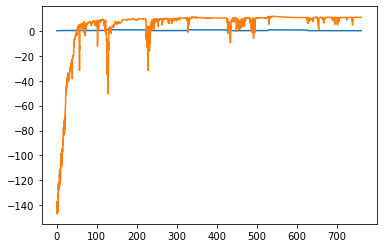

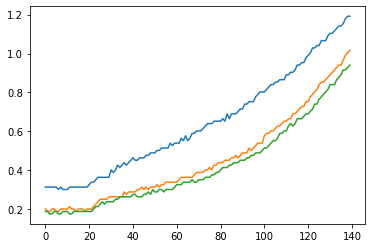

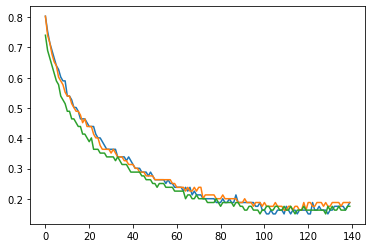

param


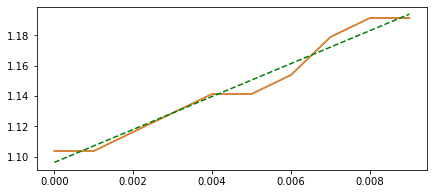

10.869595486477436


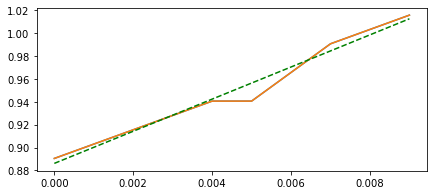

14.062080826747177


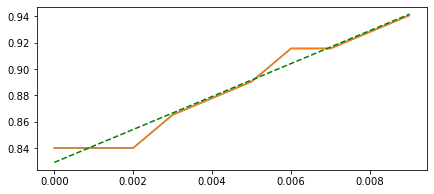

12.465890239026562
0.08905979380506251
0.0386853804351875
0.5656246350641284
0.06300406232881252
0.0392372112496875
0.37722728028373737
0.05808136251509376
0.03631496926465625
0.3747569324803807
-70.086
9.76


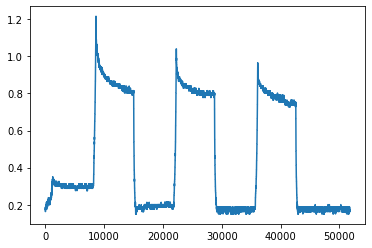

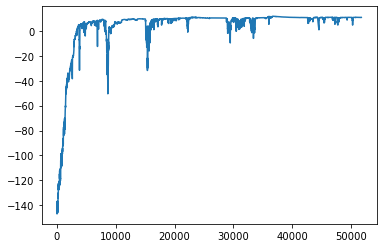

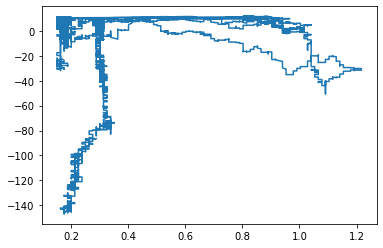

                        time     Force    Stress  Voltage
0     0 days 00:00:00.130099       NaN       NaN -144.387
1     0 days 00:00:00.150099       NaN       NaN -144.399
2     0 days 00:00:00.150341  0.000000  0.175586 -144.399
3     0 days 00:00:00.170099  0.000000  0.175586 -144.000
4     0 days 00:00:00.190099  0.000000  0.175586 -143.197
...                      ...       ...       ...      ...
51750 0 days 00:12:41.686377 -0.100332  0.163044   10.782
51751 0 days 00:12:41.706377 -0.100332  0.163044   10.785
51752 0 days 00:12:41.726377 -0.100332  0.163044   10.788
51753 0 days 00:12:41.746377 -0.100332  0.163044   10.790
51754 0 days 00:12:41.766377 -0.100332  0.163044   10.795

[51755 rows x 4 columns]


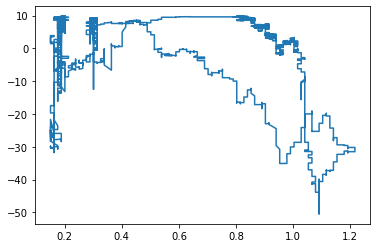

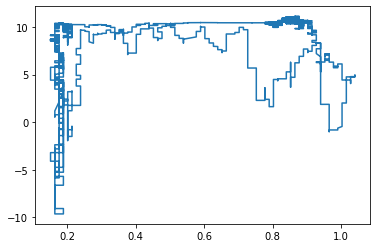

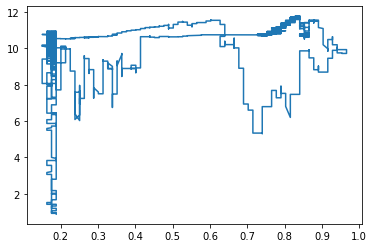

In [4]:
#df0= pd.read_csv ('g1.csv')
strGroup='1'

newDir=dir+'K203/'
#try:
#    dfarea=df0['g109.STL'].nsmallest(50)
#except:
#    dfarea=df0['G109.STL'].nsmallest(50)
#try:
#    dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
#except:
#   dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
area=8#dfarea.mean()

df2 = pd.read_csv (newDir+force, delimiter=';',decimal=',')
df3 = pd.read_csv (newDir+volt, delimiter=';',decimal=',')  

a=ChangeDataNames(df2,df3)
b,bSynchro=a.correctDataAndName(area)
    
#print(b)

c=CutterDF(b)
maxIdForce=(b.loc[2000:4000, 'Stress'].idxmax()) 
print(maxIdForce)

d=c.idOfMaxStress(2000,3000)
#                 first peak,second peak, end of first relaxation
d=c.idOfMaxStress(2000,3000,
                  d[0]+3000,d[0]+5000,
                  d[0]+7000,d[0]+11000)
print(d)
#print(e)
e=d
print(c)
            #afe=dfnew[dfStressName][maxIdForce1-60:maxIdForce1].reset_index(drop=True)
            #afr=dfnew[dfStressName][end_fisrtRel:end_fisrtRel+60].reset_index(drop=True)
            #ase=dfnew[dfStressName][maxIdForce2-60:maxIdForce2].reset_index(drop=True)
            #asr=dfnew[dfStressName][maxIdForce2+60:maxIdForce2+120].reset_index(drop=True)
slope=140
slopeOfUnload=1894
f=c.cutPartOfRange(e[0]-slope,e[0],e[0]+slopeOfUnload,e[0]+slopeOfUnload+slope,
                   e[1]-slope,e[1],e[1]+slopeOfUnload,e[1]+slopeOfUnload+slope,
                   e[2]-slope,e[2],e[2]+slopeOfUnload,e[2]+slopeOfUnload+slope)
#print(f)
h=Calculus()
#print(b.time)
plt.plot(b.timeF,b.Stress)
plt.plot(b.timeV,b.Voltage)
plt.show()

plt.plot(f[0])
plt.plot(f[2])
plt.plot(f[4])
plt.show()
plt.plot(f[1])
plt.plot(f[3])
plt.plot(f[5])
plt.show()
#plot_histeresis(stress_1,stress_2,extension,xlabel,ylabel,title,label_1,label_2)


l=Parameters(b)
print('param')
print(l.young(f[0],10))
print(l.young(f[2],10))
print(l.young(f[4],10))
#print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

print(l.areaOfHisteresis(f[0],f[1]))
print(l.areaOfHisteresis(f[2],f[3]))
print(l.areaOfHisteresis(f[4],f[5]))
#print(l.dropOfStress(e[0],e[2]))



#print(l.inflectionPoint(f[0],60))
#print(l.inflectionPoint(f[2],60))

print(l.voltMax(0,1000))
print(l.voltMax(e[2]-400,e[2]+400))



plt.plot(bSynchro.Stress)
plt.show()
plt.plot(bSynchro.Voltage)
plt.show()
plt.plot(bSynchro.Stress,bSynchro.Voltage)
plt.show()
print(bSynchro)

bSynchro.time = bSynchro.time.astype(np.int64) / 10**6

dfCUT_1=bSynchro.iloc[6000:18000]
plt.plot(dfCUT_1.Stress,dfCUT_1.Voltage)

plt.show()

dfCUT_2=bSynchro.iloc[20000:30000]
plt.plot(dfCUT_2.Stress,dfCUT_2.Voltage)
plt.show()

dfCUT_3=bSynchro.iloc[35000:45000]
plt.plot(dfCUT_3.Stress,dfCUT_3.Voltage)
plt.show()



In [12]:
def dataProcessing(numGroup):
    #df0= pd.read_csv ('g'+str(numGroup)+'.csv')
   
    dfG= pd.DataFrame({'A' : []})
    
    for i in range(1,5):
        strGroup=nameOfGroup+str(numGroup)+str(i).zfill(2)
        newDir=dir+strGroup+'/'
        print(newDir)

        try:
            '''
            try:
                dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
            except:
                dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
            area=dfarea.mean()
            '''
            area=8
            dfForce = pd.read_csv (newDir+force, delimiter=';',decimal=',')
            dfVolt = pd.read_csv (newDir+volt, delimiter=';',decimal=',') 
            cdata=ChangeDataNames(dfForce,dfVolt)
            changedata,changedataSynchro=cdata.correctDataAndName(area)
            cutedf=CutterDF(changedata)
            imaxs=cutedf.idOfMaxStress(2000,3000)
            imaxs=cutedf.idOfMaxStress(2000,3000,
                  imaxs[0]+3000,imaxs[0]+5000,
                  imaxs[0]+7000,imaxs[0]+11000)
            #first peak,second peak, end of first relaxation
            #e=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
            #e=c.idOfMaxStress(0,4000,12500,15000,d[1]-200 ,d[1]-60)
            #imaxs.append(imaxs[1]-180)
            e=imaxs

            slope=140
            slopeOfUnload=1894
            f=cutedf.cutPartOfRange(e[0]-slope,e[0],e[0]+slopeOfUnload,e[0]+slopeOfUnload+slope,
                                   e[1]-slope,e[1],e[1]+slopeOfUnload,e[1]+slopeOfUnload+slope,
                                   e[2]-slope,e[2],e[2]+slopeOfUnload,e[2]+slopeOfUnload+slope)
            
            
            print(imaxs)
            #f=cutedf.cutPartOfRange(imaxs[0]-70,imaxs[0],imaxs[2],imaxs[2]+70,imaxs[1]-70,imaxs[1],imaxs[1]+70,imaxs[1]+140)

            parameters=Parameters(changedata)

            #print(l.young(f[0],10))
            #print(l.young(f[2],10))
            #print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

            #print(l.areaOfHisteresis(f[0],f[1]))
            #print(l.areaOfHisteresis(f[2],f[3]))
            #print(l.areaOfHisteresis(f[0],f[2]))

                
            listOfParameters=[parameters.young(f[0],60-10),
                              parameters.young(f[2],60-10),
                              parameters.young(f[4],60-10),
                              parameters.areaOfHisteresis(f[0],f[1]),
                              parameters.areaOfHisteresis(f[2],f[3]),
                              parameters.areaOfHisteresis(f[4],f[5]),]
            
            #print('DUPAAAAAAA')

            #listOfParameters.append(((listOfParameters[0]-listOfParameters[1])/listOfParameters[0]))

            listOfParameters.append(parameters.voltMax(2000,3000))
            listOfParameters.append(parameters.voltMax(imaxs[0]+3000,imaxs[0]+5000))
            listOfParameters.append(parameters.voltMax(imaxs[0]+7000,imaxs[0]+11000))

            #listOfParameters.append(((parameters.voltMax(0,2000)-parameters.voltMax(imaxs[2],imaxs[2]+2000))/parameters.voltMax(0,2000))*100)
            #listOfParameters.append(area)
            dfPara = pd.DataFrame(listOfParameters, columns=[strGroup])
            print(dfPara)
            dfG=pd.concat([dfPara, dfG.reindex(dfG.index)],axis=1)
            



            j=Ploting()
            j.plotData(changedata)
            
            
            changedataSynchro.time = changedataSynchro.time.astype(np.int64) / 10**6
            #js=Ploting()
            j.plotStressVoltage(changedataSynchro,6000,18000)
            j.plotStressVoltage(changedataSynchro,20000,30000)
            j.plotStressVoltage(changedataSynchro,35000,45000)
            '''
            dfCUT_2=changedataSynchro.iloc[20000:30000]
            plt.plot(dfCUT_2.Stress,dfCUT_2.Voltage)
            plt.show()

            dfCUT_3=changedataSynchro.iloc[35000:45000]
            plt.plot(dfCUT_3.Stress,dfCUT_3.Voltage)
            plt.show()
            '''
            
            
            ####j.plot_histeresis(f[0],f[2],'Strain','Stress [MPa]','Histeresis between first and second extension '+strGroup,"first peak","second peak")
            j.plot_histeresis(f[0],f[1],'Strain','Stress [MPa]','Histeresis between first extension and relief  '+strGroup,"extension","relief")
            #j.plot_histeresis(f[2],f[3],'Strain','Stress [MPa]','Histeresis between second extension and relief '+strGroup,"extension","relief")
            
            
            
            
        except:
            print(f'próbka: {strGroup}  jest uszkodzona/odrzucona etc...')
    
    dfG.drop('A', inplace=True, axis=1)
    return dfG.T

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K101/
[2787, 6815, 10845]


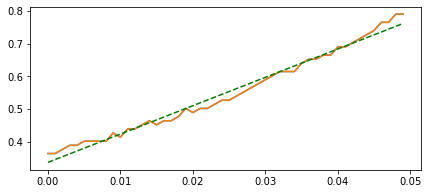

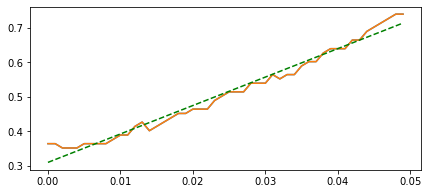

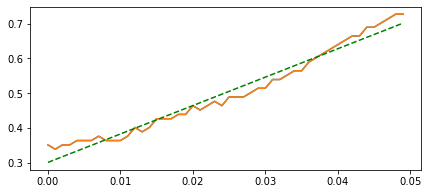

0.05179164003934376
0.03513601450078125
0.04781585213825001
0.032395632820031245
0.046574208279375015
0.030965848097406254
        K101
0   8.673006
1   8.260463
2   8.176147
3   0.321589
4   0.322492
5   0.335129
6 -29.727000
7  -0.243000
8  -0.188000


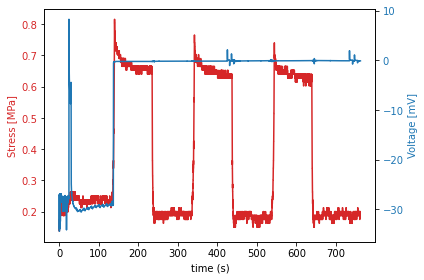

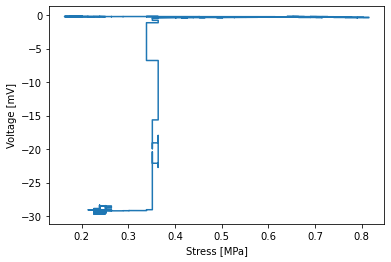

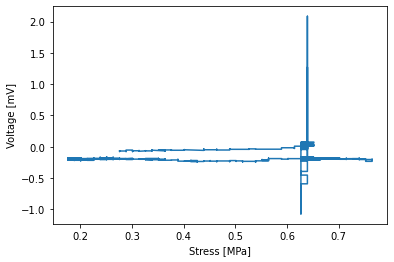

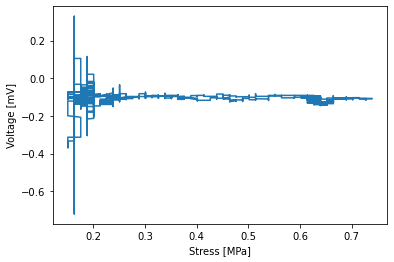

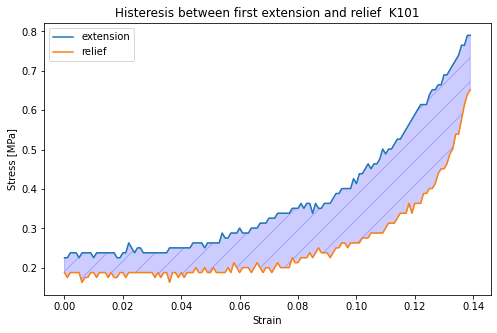

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K102/
[2379, 6405, 10433]


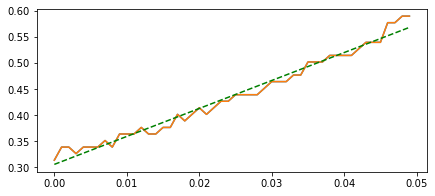

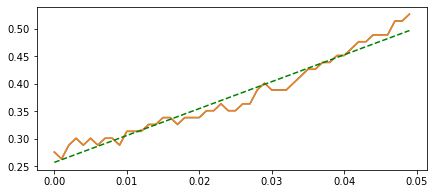

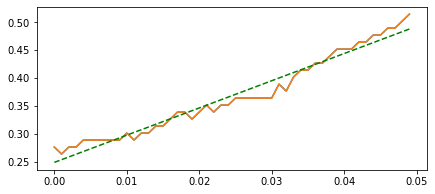

0.044862257634687513
0.0297680725024375
0.03997092382893751
0.03003772942384375
0.039099274393375
0.03081535380109375
       K102
0  5.355809
1  4.893282
2  4.880031
3  0.336456
4  0.248511
5  0.211869
6  0.843000
7  0.534000
8  0.162000


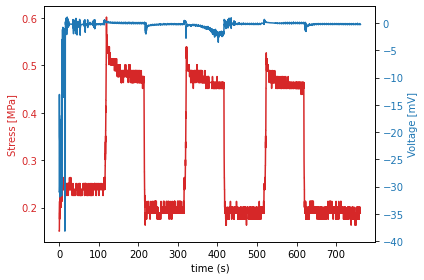

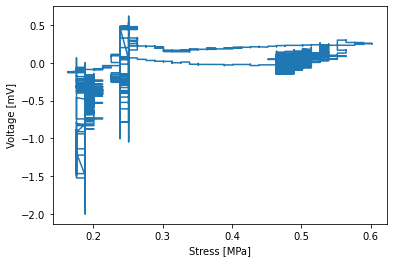

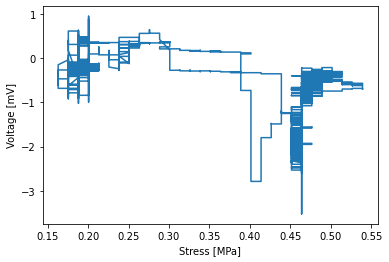

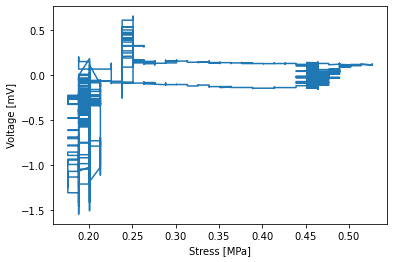

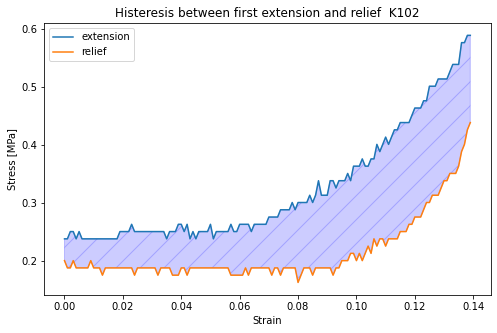

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K103/
[2954, 6457, 10484]


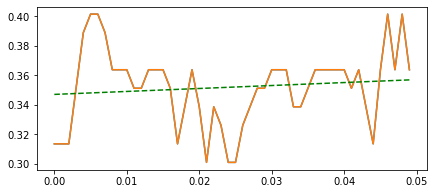

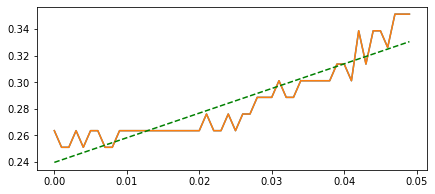

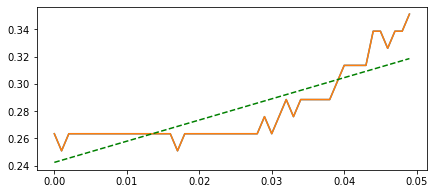

0.042636076756218756
0.0248453892439375
0.034659432673906254
0.027786479652093753
0.03402606863337501
0.02647586429928125
        K103
0   0.200552
1   1.856141
2   1.555024
3   0.417268
4   0.198300
5   0.221895
6  -0.538000
7  30.307000
8  19.231000


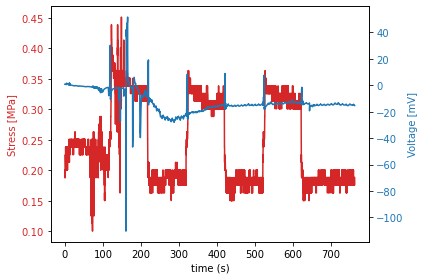

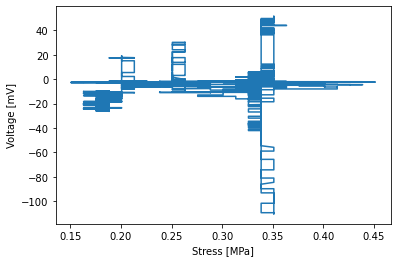

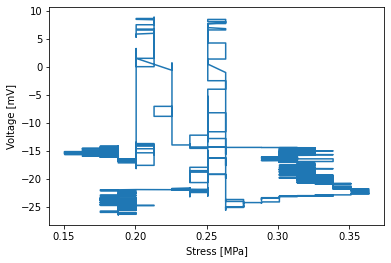

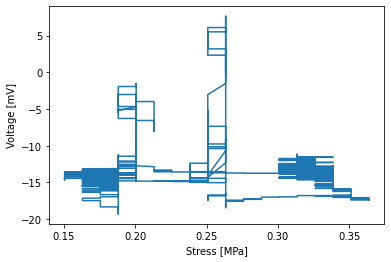

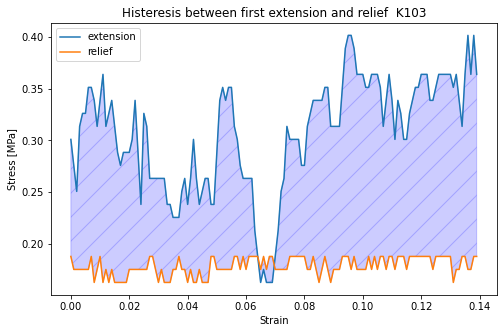

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K104/
[2221, 6249, 10277]


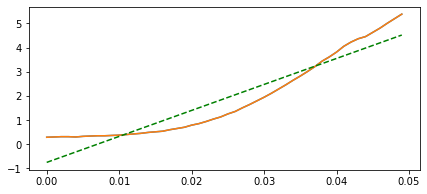

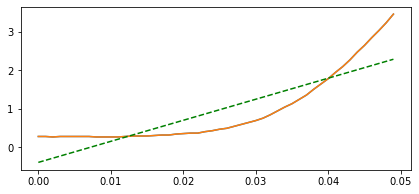

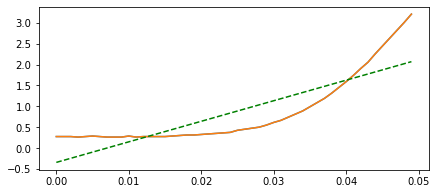

0.11523463762759381
0.19912091576278126
0.06659103865443752
0.17670858570290626
0.06223271176631253
0.16762827937843752
         K104
0  107.470988
1   54.803580
2   49.274318
3   -0.727961
4   -1.653639
5   -1.693572
6   53.600000
7   16.427000
8   42.397000


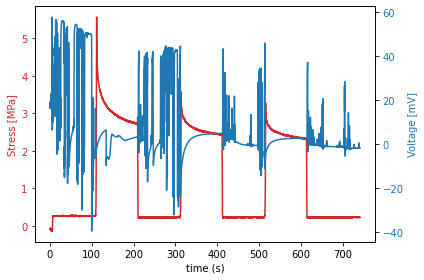

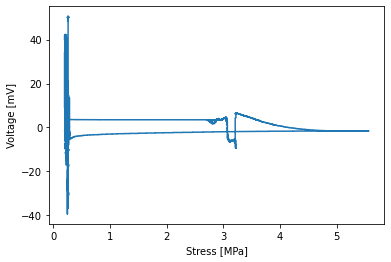

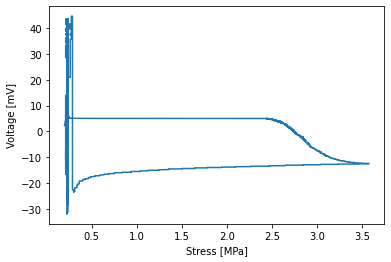

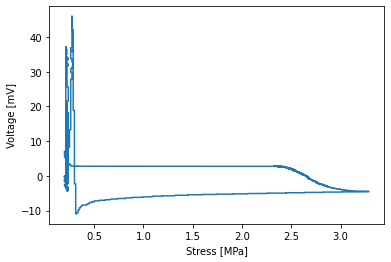

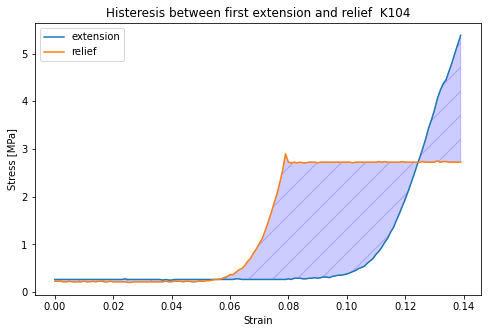

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K201/
[2158, 6187, 10214]


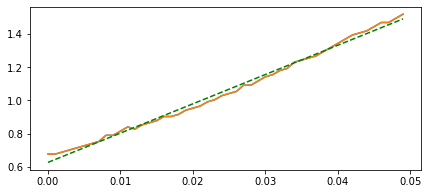

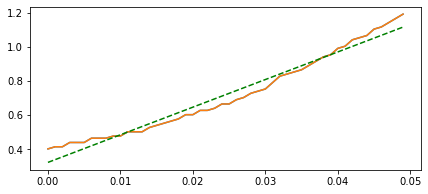

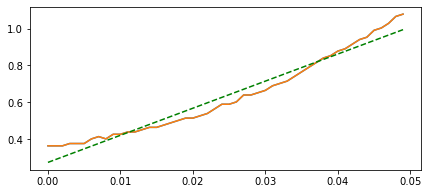

0.08418727408568752
0.039337565306812504
0.057836803918468765
0.0343208263321875
0.05246888460690627
0.03343035974446875
        K201
0  17.580292
1  16.190904
2  14.704546
3   0.532737
4   0.406592
5   0.362854
6   9.841000
7   8.739000
8   9.063000


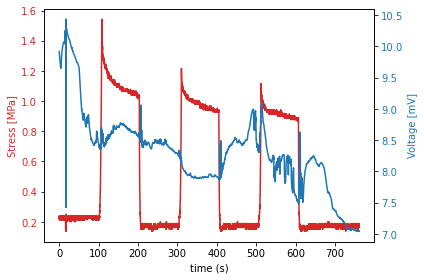

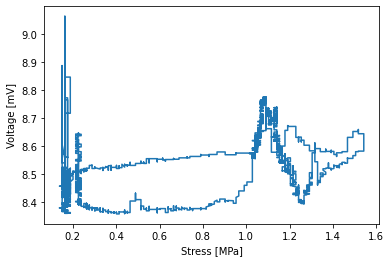

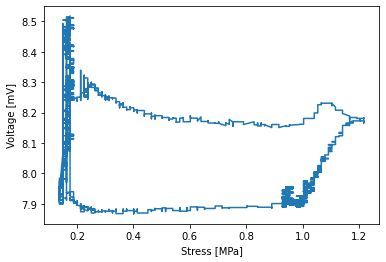

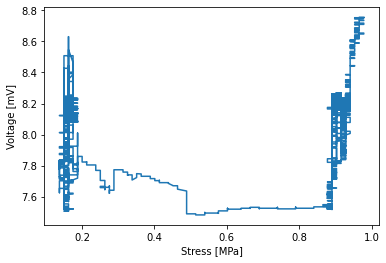

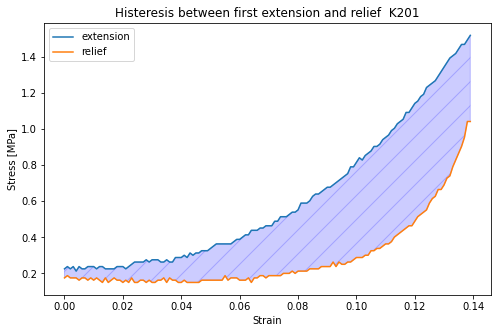

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K202/
[2453, 6481, 10509]


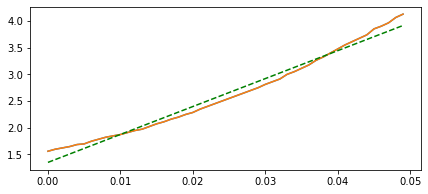

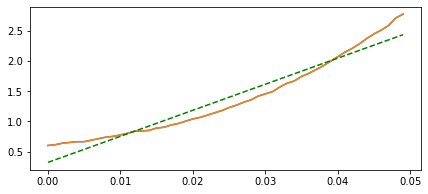

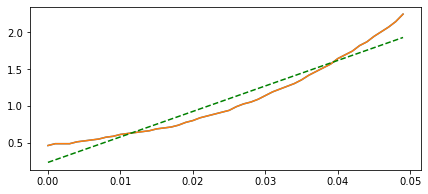

0.19350845134403133
0.06325487082709375
0.09306689804846878
0.05086981602784375
0.07605386557125002
0.04352027566075
        K202
0  52.390970
1  43.056092
2  34.548694
3   0.673116
4   0.453406
5   0.427770
6   9.494000
7   9.187000
8  23.590000


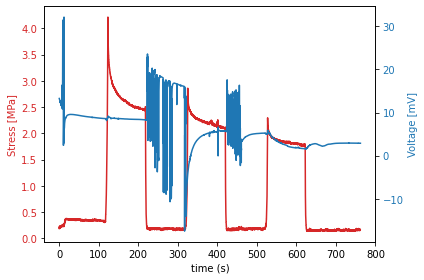

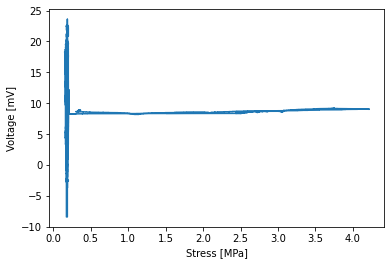

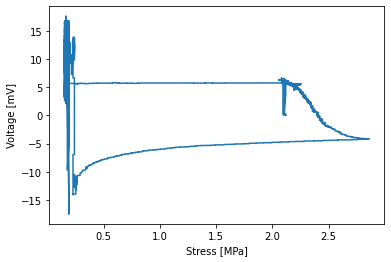

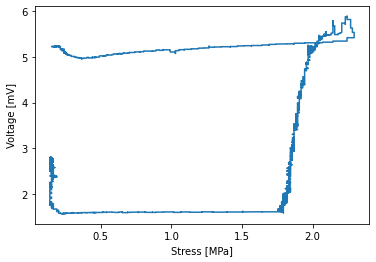

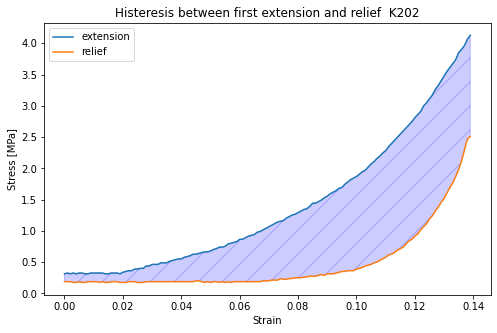

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K203/
[2528, 6556, 10584]


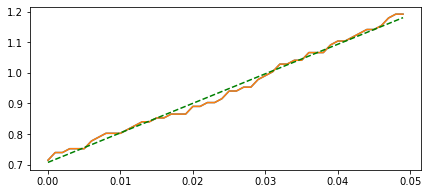

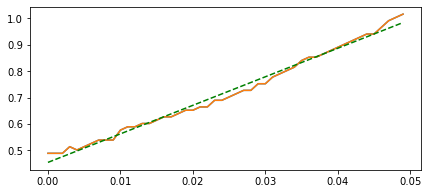

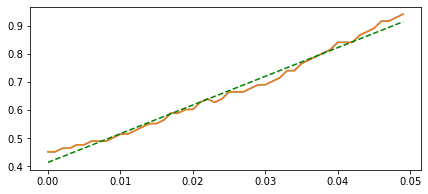

0.08905979380506251
0.0386853804351875
0.06300406232881252
0.0392372112496875
0.05808136251509376
0.03631496926465625
        K203
0   9.635399
1  10.800758
2  10.197306
3   0.565625
4   0.377227
5   0.374757
6   5.211000
7   9.274000
8   9.792000


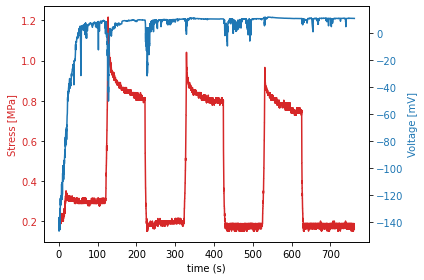

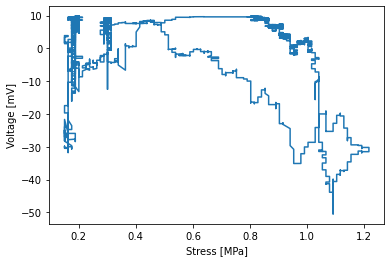

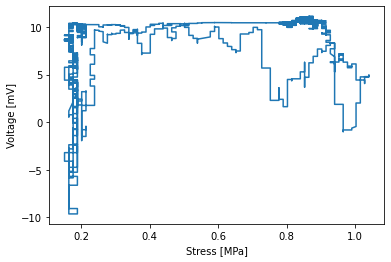

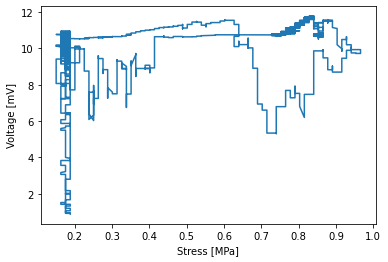

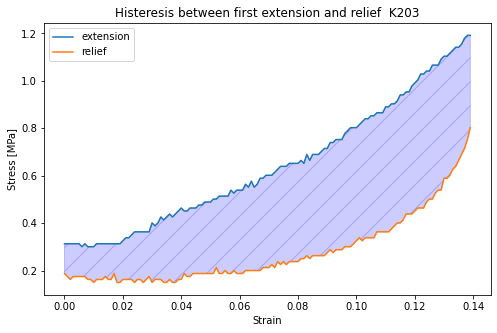

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K204/
próbka: K204  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K301/
[2192, 6220, 10248]


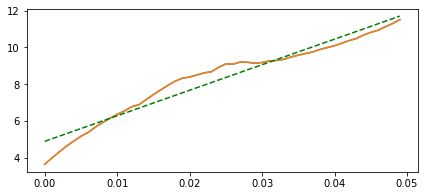

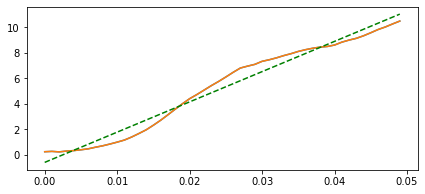

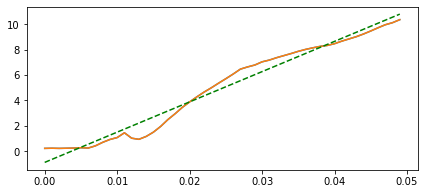

0.45891315439068764
0.5195342505615937
0.2722964088392188
0.5238987832041251
0.2592654019016251
0.5283198047056562
         K301
0  139.049389
1  237.622735
2  238.476729
3   -0.132097
4   -0.924002
5   -1.037757
6    0.326000
7    0.183000
8    0.173000


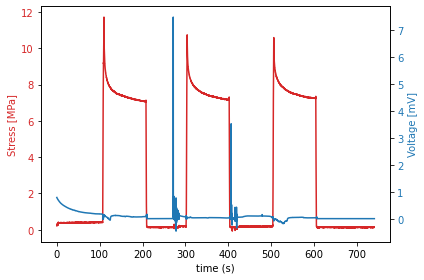

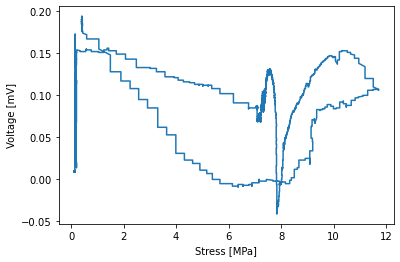

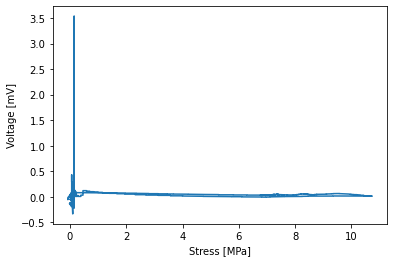

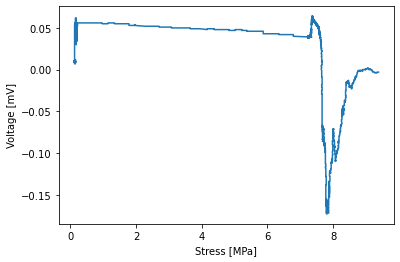

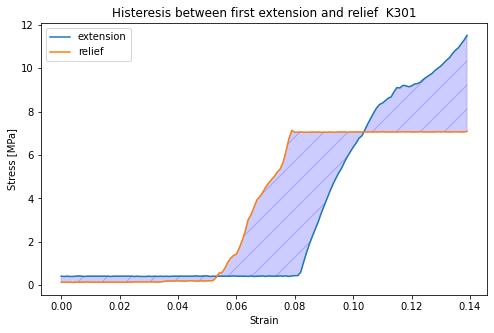

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K302/
[2660, 6688, 10716]


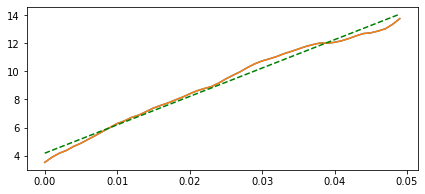

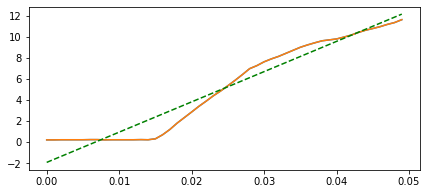

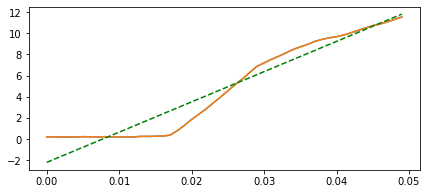

0.4943313501424377
0.6391146404689375
0.2623193749885626
0.6075405033558438
0.24755132337359387
0.615542210199875
         K302
0  202.495874
1  287.265042
2  285.558866
3   -0.292887
4   -1.316034
5   -1.486524
6    0.702000
7    0.666000
8    0.737000


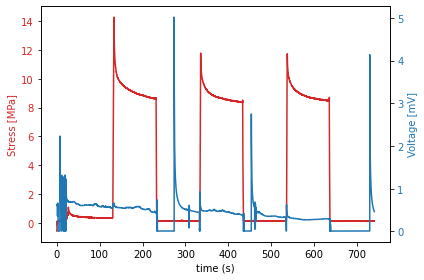

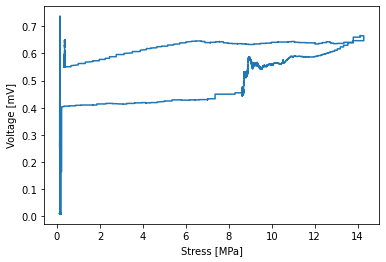

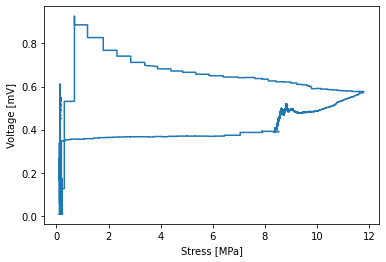

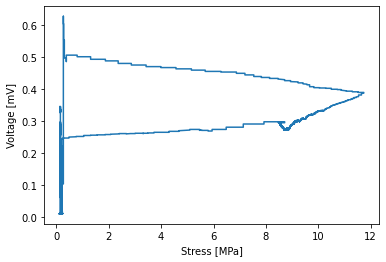

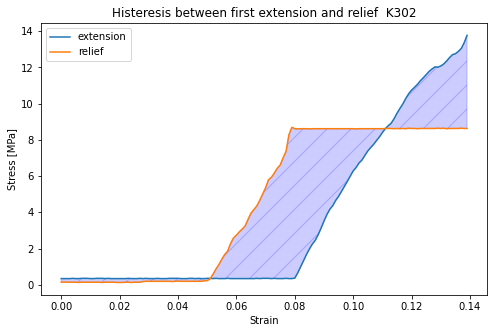

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K303/
[2743, 6771, 10799]


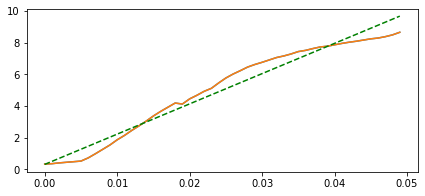

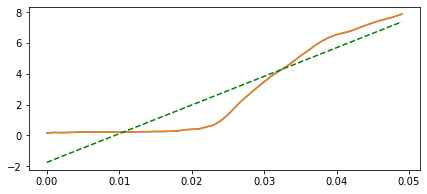

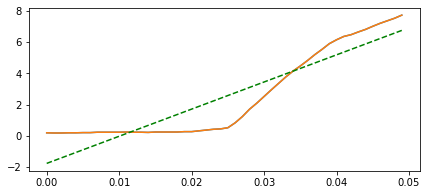

0.2663202354618751
0.3685427158013125
0.14870887789909387
0.37405485007603123
0.1335583038523126
0.379441588992375
         K303
0  190.899538
1  186.364593
2  174.132892
3   -0.383833
4   -1.515350
5   -1.841018
6   -0.276000
7   -0.020000
8    0.010000


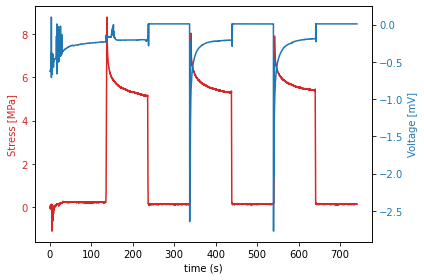

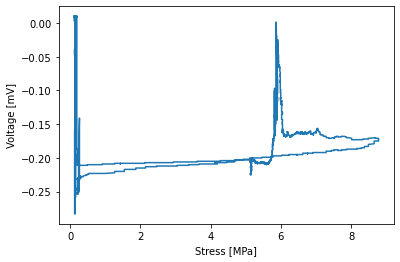

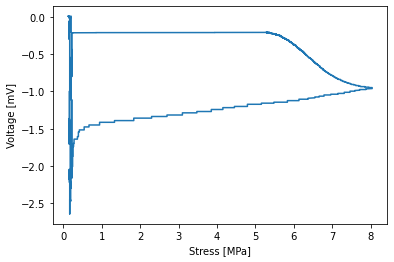

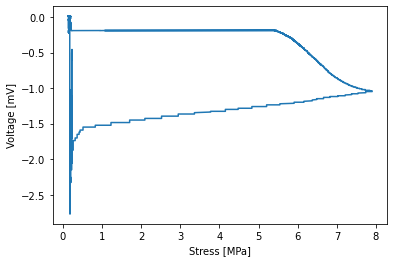

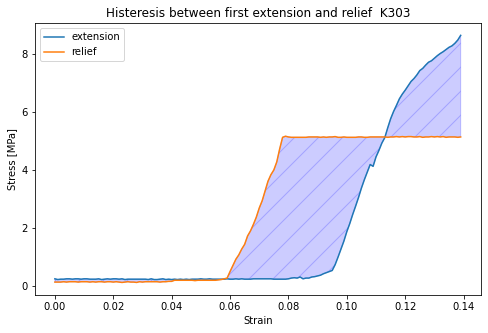

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K304/
[2574, 6602, 10628]


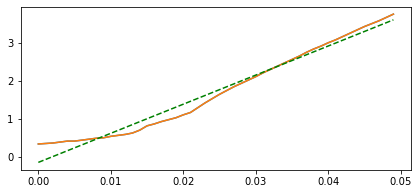

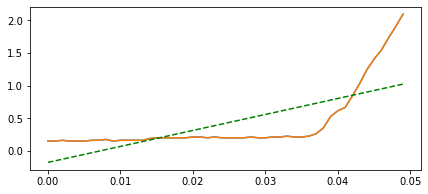

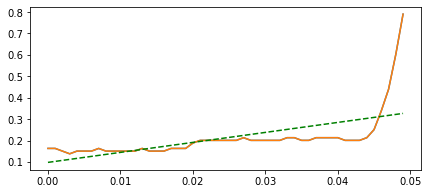

0.10357073551496879
0.11485212010103125
0.03105995102656252
0.07139456174046874
0.021032734628937504
0.02339056628584375
        K304
0  76.435828
1  24.460397
2   4.667431
3  -0.108924
4  -1.298605
5  -0.112103
6   0.128000
7   0.035000
8   0.039000


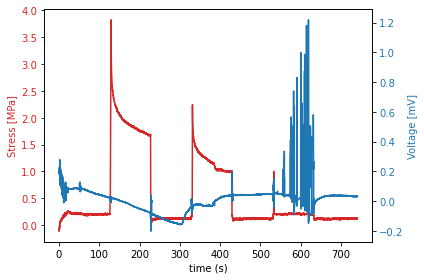

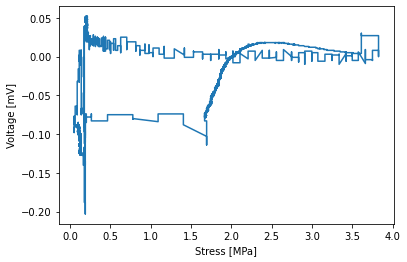

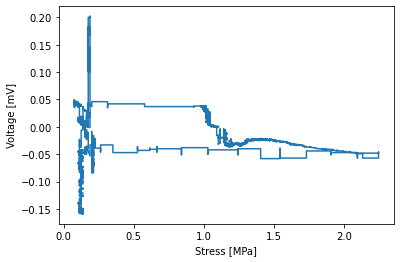

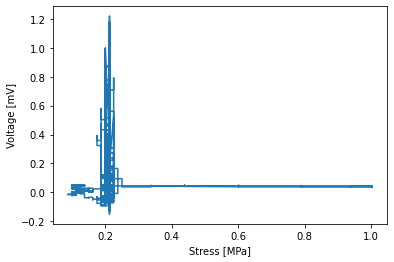

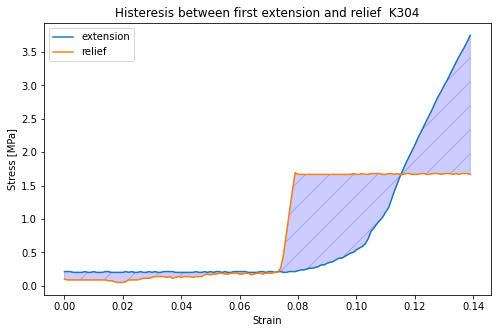

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K401/
[2353, 6381, 10409]


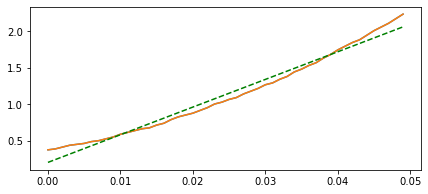

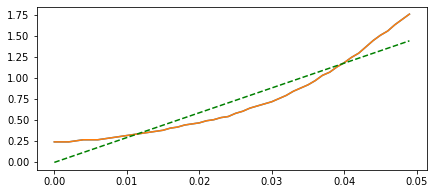

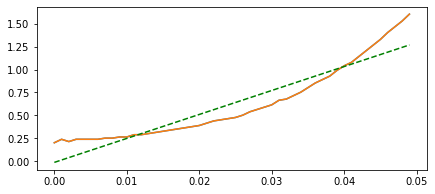

0.07821735183631251
0.10266769554518751
0.049628185045250024
0.09569442586878124
0.044034494244562516
0.090640036034625
        K401
0  37.831563
1  29.475941
2  26.176813
3  -0.312595
4  -0.928227
5  -1.058387
6  -0.014000
7   0.576000
8   0.025000


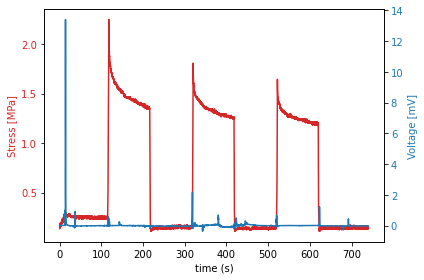

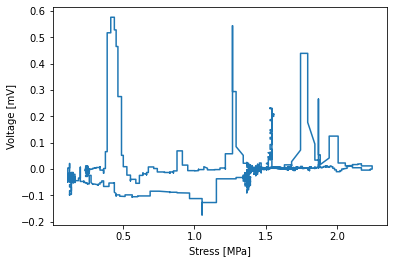

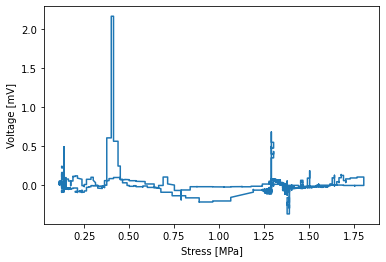

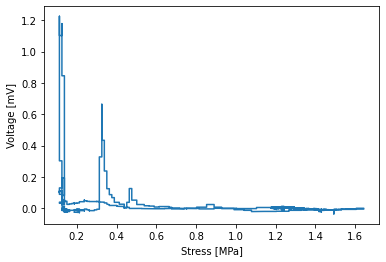

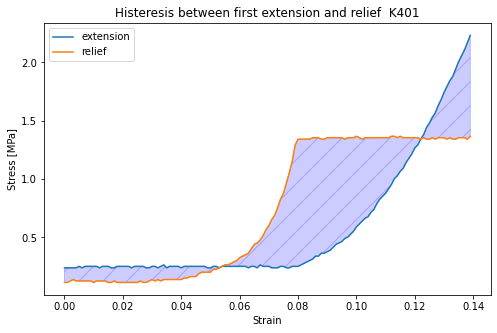

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K402/
[3000, 7084, 11112]


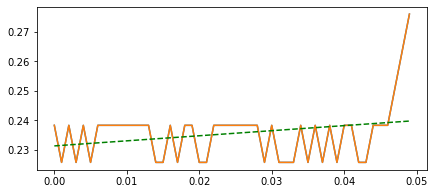

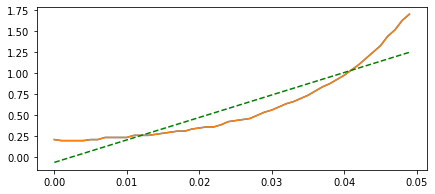

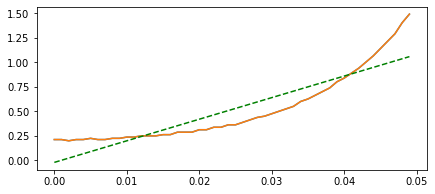

0.032602589609625005
0.16049200824453125
0.04314404482521877
0.08838877890500002
0.03886099145096876
0.0823310612648125
        K402
0   0.171639
1  26.733289
2  22.014665
3  -3.922677
4  -1.048690
5  -1.118604
6   1.048000
7   0.005000
8   0.074000


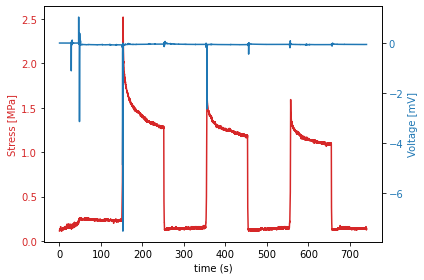

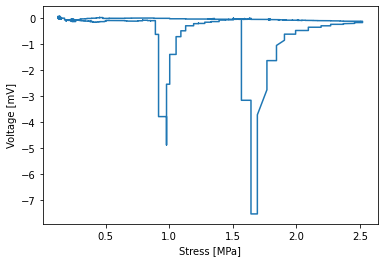

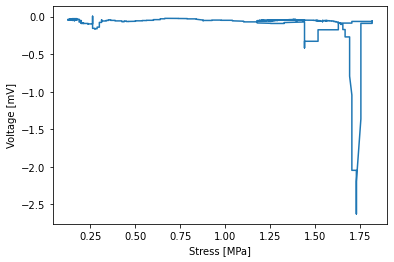

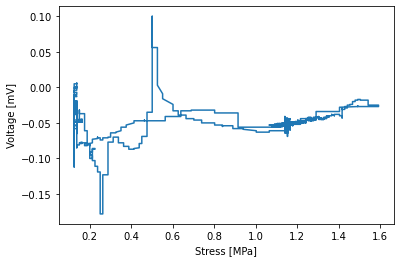

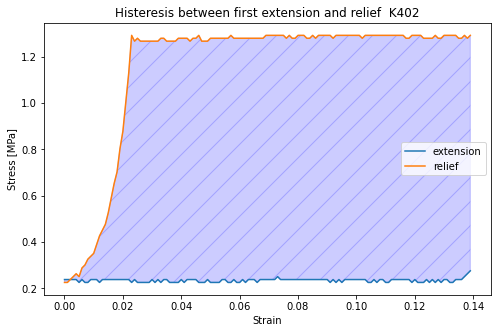

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K403/
[2512, 6540, 10568]


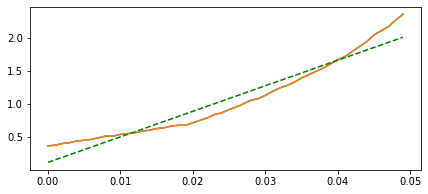

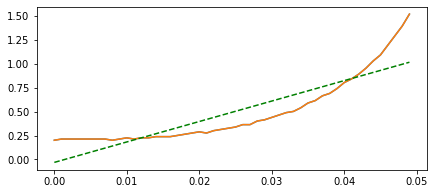

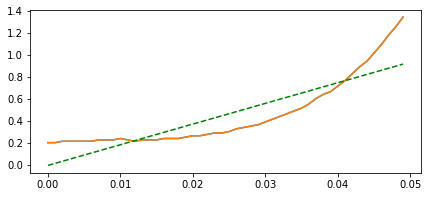

0.07295601686253127
0.0751696697325
0.03852235874353126
0.071488664669625
0.03623973989803126
0.06888621248731251
        K403
0  38.640990
1  21.345562
2  18.796840
3  -0.030342
4  -0.855771
5  -0.900847
6  -0.241000
7  -0.166000
8  -0.023000


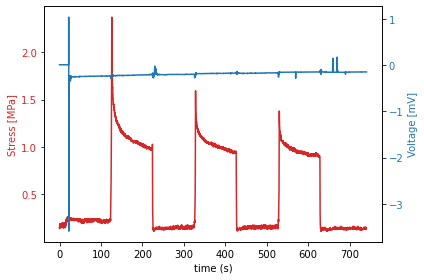

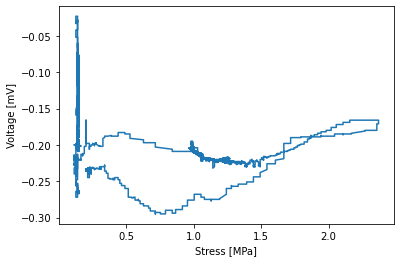

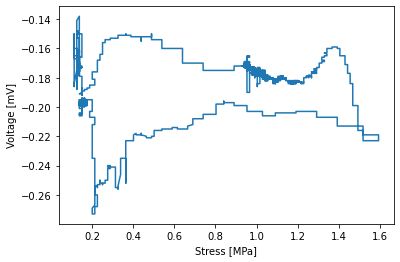

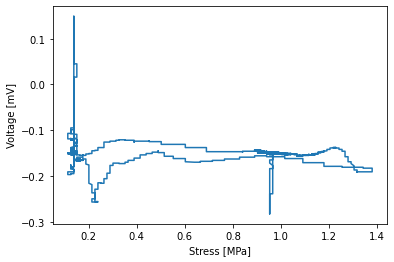

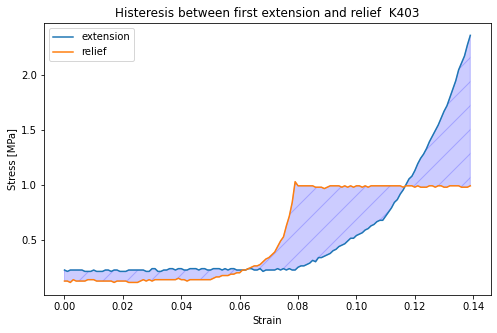

D:/OneDrive/PHD/Badania - przebieg kwadratowy - piezo/logs/K404/
[2587, 6615, 10643]


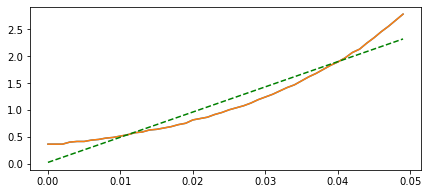

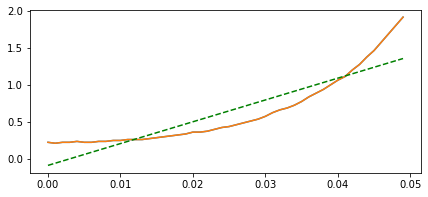

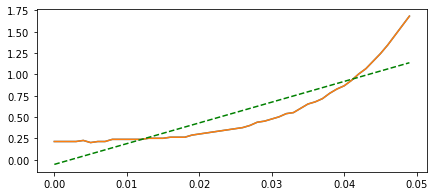

0.07773446553687502
0.10596618246834377
0.045545801156406274
0.09647204166184375
0.04077989581946877
0.08985619486615623
        K404
0  46.894236
1  29.496426
2  24.280329
3  -0.363181
4  -1.118132
5  -1.203443
6   0.034000
7  -0.055000
8  -0.114000


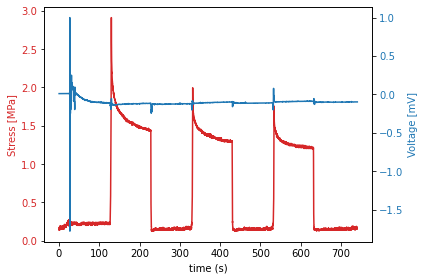

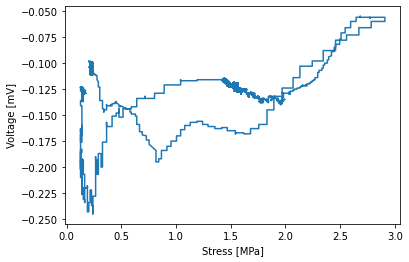

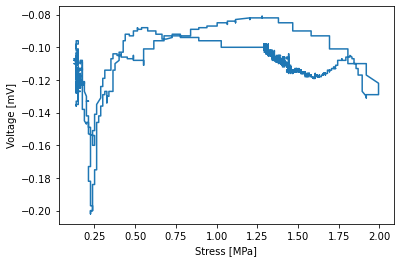

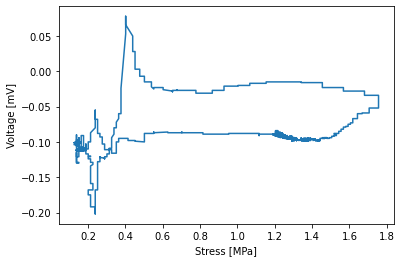

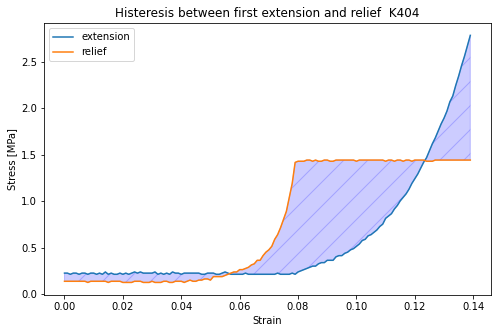

{1:                0          1          2         3         4         5       6  \
K104  107.470988  54.803580  49.274318 -0.727961 -1.653639 -1.693572  53.600   
K103    0.200552   1.856141   1.555024  0.417268  0.198300  0.221895  -0.538   
K102    5.355809   4.893282   4.880031  0.336456  0.248511  0.211869   0.843   
K101    8.673006   8.260463   8.176147  0.321589  0.322492  0.335129 -29.727   

           7       8  
K104  16.427  42.397  
K103  30.307  19.231  
K102   0.534   0.162  
K101  -0.243  -0.188  , 2:               0          1          2         3         4         5      6  \
K203   9.635399  10.800758  10.197306  0.565625  0.377227  0.374757  5.211   
K202  52.390970  43.056092  34.548694  0.673116  0.453406  0.427770  9.494   
K201  17.580292  16.190904  14.704546  0.532737  0.406592  0.362854  9.841   

          7       8  
K203  9.274   9.792  
K202  9.187  23.590  
K201  8.739   9.063  , 3:                0           1           2         3         4         5 

In [13]:

d =  {j: dataProcessing(j) for j in numberOfGroup}
print(d)
#dfData = pd.DataFrame.from_dict(d, orient="index")
#print(dfData)

In [7]:
#print(dfData) col_one_list = df['one'].tolist()
#dfData.iloc[:, dfData.columns.get_level_values(0)=='1'] 
#print(d)
l=list(d.values())

def returnDfOfGroups(l,parametr):
    newDF=pd.DataFrame({'A' : []})
    j=0
    for i in numberOfGroup:  
        newDF=pd.concat([newDF.reindex(newDF.index), pd.DataFrame(l[j][parametr].tolist(), columns=['G'+str(i)])], axis=1)
        j=j+1
    newDF.drop('A', inplace=True, axis=1)
    return newDF


parameters={'Young_1':0,'Young_2':1,'AreaOfHis_1':2,'AreaOfHis_2':3,
            'AreaOfHis_pseudo':4,'DropOfStress':5,'DropOfYoung':6,
            'InflectionPoint_1':7,'InflectionPoint_2':8,'InflectionPointDrop':9,
            'Volt_1':10,'Volt_2':11,'VoltDrop':12,'Area':13}

#print(returnDfOfGroups(l,parameters['Young_1']))

In [14]:
ploting=Ploting()
# box_scatter_plot(df,ylabel,               title,     ylim)    
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_1']),'Young_1','Elastic Modulus [MPa]','first peak',0,300)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_2']),'Young_2','Elastic Modulus [MPa]','second peak',0,300)
                 
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung','','Drop of Elastic Modulus',-1,0.3)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo','_','Histeresis',0,1)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress','','Drop of Stress',0,1)

#ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1','_','Histeresis of first extension an unload',0,1)

#ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_2']),'AreaOfHis_2','_','Histeresis of second extension',0,1)


#ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Area']),'Area','_','Mean Area [mm2]',5,50)

'''
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_1']),'InflectionPoint_1','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_2']),'InflectionPoint_2','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPointDrop']),'InflectionPointDrop','[mm]','Drop of Stress Deriative',0,200)
'''

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Volt_1']),'Volt_1','Voltage [mV/mm2]','first peak',-10,250)#30)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Volt_2']),'Volt_2','Voltage [mV/mm2]','second peak',-10,250)#30)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['VoltDrop']),'VoltDrop','Pv=((V1-V2)/V1)*100% [%]','Percentage difference between the first and second peak',-50,250)

KeyError: 0

In [ ]:

returnDfOfGroups(l,parameters['Area']).describe()


In [ ]:
print('first peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_1']),'Young_1')
print('second peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_2']),'Young_2')
print('Drop off stress')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress')
print('niby histereza')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo')
print('spadek Modulow')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung')
print('His 1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1')
print('His 2')
#StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_2']))
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Area']),'Area')
print('Area')
'''
print('InflectionPoint_1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_1']))
print('InflectionPoint_2')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_2']))
print('InflectionPointDrop')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPointDrop']))
'''

print('Volt_1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Volt_1']),'Volt_1')
print('Volt_2')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Volt_2']),'Volt_2')
print('VoltDrop')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['VoltDrop']),'VoltDrop')
